In [1]:
!pip install statsmodels
!pip install tensorflow
!pip install yfinance

In [2]:
#DATA

import yfinance as yf
import matplotlib.pyplot as plt

# Descargar datos históricos de Tesla (TSLA)
tesla_data = yf.download('TSLA', start='2018-12-01', end='2023-12-01')

# Mostrar las primeras filas del dataset
print(tesla_data.head())



[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                             
2018-12-03  23.899332  24.400000  23.466667  24.000000  124597500
2018-12-04  23.980000  24.578667  23.466667  23.736668  126928500
2018-12-06  24.204000  24.492001  23.384001  23.733999  117637500
2018-12-07  23.864668  25.299334  23.843332  24.600000  172668000
2018-12-10  24.343332  24.398666  23.541332  24.000000   99202500


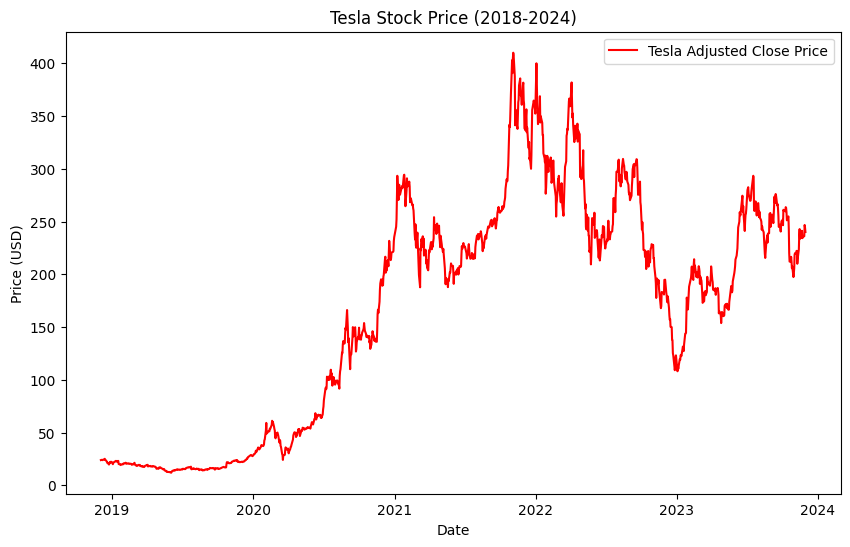

In [3]:
##### PINTAR DATOS ############

# Gráfico del precio de cierre ajustado
plt.figure(figsize=(10, 6))
plt.plot(tesla_data['Close'], label='Tesla Adjusted Close Price', color='red')
plt.title('Tesla Stock Price (2018-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [4]:
### Completar por parte del alumno ####
# Aplicar técncias de Preprocessing
# Normalización, Correlación, Transformada de Fourier



In [14]:
### Completar por parte del alumno ####

# Realizar un filtrado para realizar preparar los datos
# Medias moviles, smoothing,


In [15]:
### Completar por parte del alumno ####


# Aplicar técnicas de predicción de series temporales
# Buscar dos modelos y compararlos y sacar conclusiones sobre el comportamiento de cada uno.
# Medir en funciñon de MAE,MSE,RMSE,MAPE, sMAPE, MASE

# Descomposición de series temporales

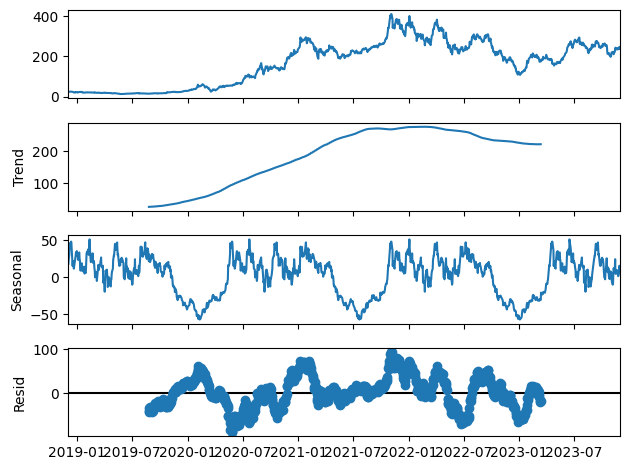

In [5]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(tesla_data['Close'], model='additive', period=365)
decomposition.plot()
plt.show()

## Normalización de los Datos

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Escalar el precio de cierre
scaler = MinMaxScaler(feature_range=(0, 1))
tesla_data['Close_Scaled'] = scaler.fit_transform(tesla_data[['Close']])

# Visualizar los datos escalados
print(tesla_data.head())

Price           Close       High        Low       Open     Volume Close_Scaled
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA             
Date                                                                          
2018-12-03  23.899332  24.400000  23.466667  24.000000  124597500     0.030067
2018-12-04  23.980000  24.578667  23.466667  23.736668  126928500     0.030270
2018-12-06  24.204000  24.492001  23.384001  23.733999  117637500     0.030833
2018-12-07  23.864668  25.299334  23.843332  24.600000  172668000     0.029980
2018-12-10  24.343332  24.398666  23.541332  24.000000   99202500     0.031183


# Filtrado: Aplicar media móvil para suavizar los datos

In [7]:
tesla_data['Close_Smoothed'] = tesla_data['Close_Scaled'].rolling(window=10).mean().fillna(0)

# Transformada de Fourier para analizar la frecuencia de los datos

In [10]:
from scipy.fft import fft, ifft
import numpy as np

fft_close = fft(tesla_data['Close_Smoothed'].values)
fft_freq = np.fft.fftfreq(len(fft_close))

# Filtrar las frecuencias más altas

In [11]:
fft_filtered = fft_close.copy()
fft_filtered[np.abs(fft_freq) > 0.1] = 0
filtered_signal = ifft(fft_filtered)

# Mostrar el resultado del filtrado de Fourier

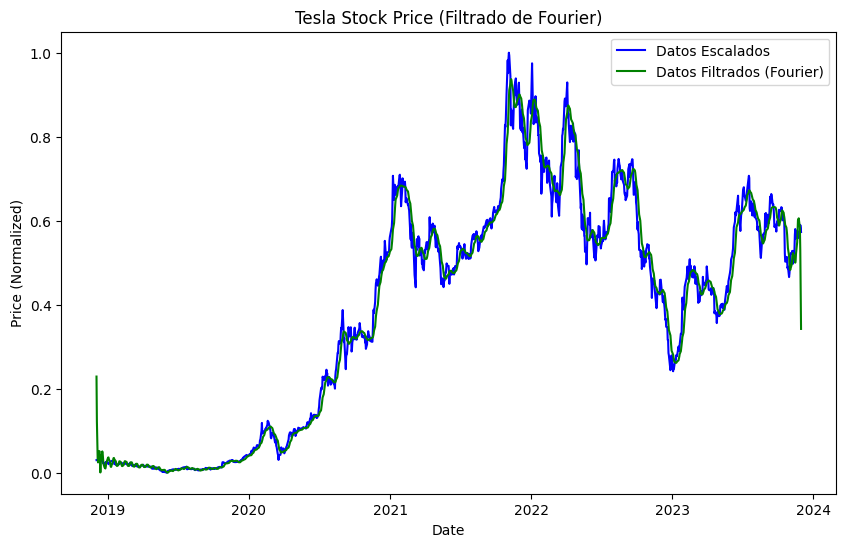

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(tesla_data.index, tesla_data['Close_Scaled'], label='Datos Escalados', color='blue')
plt.plot(tesla_data.index, np.abs(filtered_signal), label='Datos Filtrados (Fourier)', color='green')
plt.title('Tesla Stock Price (Filtrado de Fourier)')
plt.xlabel('Date')
plt.ylabel('Price (Normalized)')
plt.legend()
plt.show()

## División de Datos

In [13]:
# Definir tamaño de entrenamiento (80% de los datos)
train_size = int(len(tesla_data) * 0.8)
train_data = tesla_data[:train_size]
test_data = tesla_data[train_size:]

# Mostrar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")


Tamaño del conjunto de entrenamiento: 1005
Tamaño del conjunto de prueba: 252


# Modelos de Predicción

Linear Regression Metrics:
MAE: 0.0017
MSE: 0.0000
RMSE: 0.0021

Random Forest Metrics:
MAE: 0.0098
MSE: 0.0002
RMSE: 0.0150

SVR Metrics:
MAE: 0.0042
MSE: 0.0000
RMSE: 0.0052

XGBoost Metrics:
MAE: 0.0089
MSE: 0.0001
RMSE: 0.0122



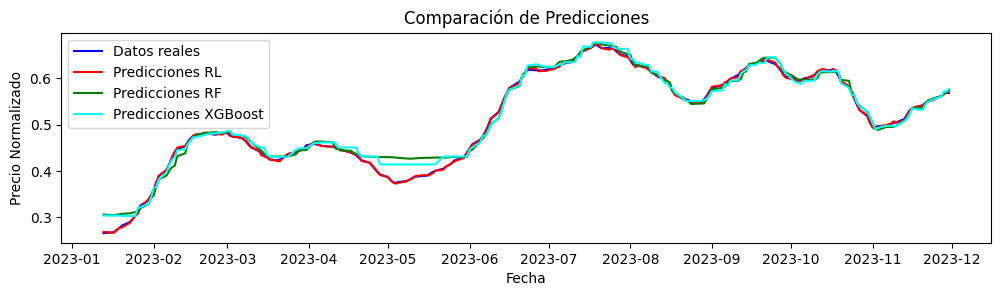

In [19]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb

# Crear retardos (lags) en los datos suavizados
def create_lag_features(data, lags):
    lagged_data = pd.DataFrame()
    for lag in range(1, lags + 1):
        lagged_data[f'lag_{lag}'] = data.shift(lag)
    lagged_data['target'] = data.values
    lagged_data.dropna(inplace=True)
    return lagged_data

lags = 30
train_lagged = create_lag_features(train_data['Close_Smoothed'], lags)
test_lagged = create_lag_features(test_data['Close_Smoothed'], lags)

# Separar características (X) y objetivo (y)
X_train = train_lagged.drop(columns=['target']).values
y_train = train_lagged['target'].values
X_test = test_lagged.drop(columns=['target']).values
y_test = test_lagged['target'].values

# Modelo 1: Regresión Lineal
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)

# Modelo 2: Bosque Aleatorio
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)

# Modelo 3: Soporte Vectorial de Regresión (SVR)
model_svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
model_svr.fit(X_train, y_train)
predictions_svr = model_svr.predict(X_test)

# Modelo 4: XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


# Métricas de evaluación
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'{model_name} Metrics:')
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print()

calculate_metrics(y_test, predictions_lr, "Linear Regression")
calculate_metrics(y_test, predictions_rf, "Random Forest")
calculate_metrics(y_test, predictions_svr, "SVR")
calculate_metrics(y_test, xgb_predictions, "XGBoost")

plt.figure(figsize=(12, 6))

# Gráfica principal
plt.subplot(2, 1, 1)
plt.plot(test_data.index[lags:], y_test, label='Datos reales', color='blue')
plt.plot(test_data.index[lags:], predictions_lr, label='Predicciones RL', color='red')
plt.plot(test_data.index[lags:], predictions_rf, label='Predicciones RF', color='green')
plt.plot(test_data.index[lags:], xgb_predictions, label='Predicciones XGBoost', color='cyan')
plt.title('Comparación de Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Precio Normalizado')
plt.legend()


In [20]:
# Calcular métricas extendidas
def calculate_metrics_extended(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    naive_mae = np.mean(np.abs(np.diff(y_true)))  # MAE del modelo naive
    mase = mae / naive_mae if naive_mae > 0 else np.nan  # Evitar división por cero

    print(f'{model_name} Metrics:')
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.4f}%')
    print(f'sMAPE: {smape:.4f}%')
    print(f'MASE: {mase:.4f}')
    print()

# Ajuste de las longitudes para ARIMA
# Calcular métricas para cada modelo
calculate_metrics_extended(y_test, predictions_lr, "Linear Regression")
calculate_metrics_extended(y_test, predictions_rf, "Random Forest")
calculate_metrics_extended(y_test, xgb_predictions, "XGBoost")
calculate_metrics_extended(y_test, predictions_svr, "SVR")


Linear Regression Metrics:
MAE: 0.0017
MSE: 0.0000
RMSE: 0.0021
MAPE: 0.3347%
sMAPE: 0.3349%
MASE: 0.3086

Random Forest Metrics:
MAE: 0.0098
MSE: 0.0002
RMSE: 0.0150
MAPE: 2.3100%
sMAPE: 2.2466%
MASE: 1.8311

XGBoost Metrics:
MAE: 0.0089
MSE: 0.0001
RMSE: 0.0122
MAPE: 2.0197%
sMAPE: 1.9768%
MASE: 1.6524

SVR Metrics:
MAE: 0.0042
MSE: 0.0000
RMSE: 0.0052
MAPE: 0.8748%
sMAPE: 0.8748%
MASE: 0.7763



# Análisis Detallado de Resultados
## Linear Regression
La Regresión Lineal presenta un rendimiento sobresaliente en la predicción temporal. Sus métricas destacan por un MAE de 0.0017 y un RMSE de 0.0021, lo que sugiere un error absoluto y cuadrático bajo, ideal para capturar tendencias simples. El MAPE de 0.3347% y el sMAPE de 0.3349% reflejan un error porcentual muy bajo, lo que significa que las predicciones son muy precisas en relación a los valores reales. Además, el MASE de 0.3086 indica que la Regresión Lineal es mucho más eficiente que un modelo ingenuo, lo que demuestra su efectividad para este conjunto de datos.

## Random Forest
El modelo Random Forest tiene un rendimiento considerablemente inferior al de la Regresión Lineal. Con un MAE de 0.0098 y un RMSE de 0.0150, los errores absolutos y cuadráticos son más altos, lo que sugiere que la complejidad del modelo no aporta beneficios significativos en este caso. Un MAPE de 2.3100% y un sMAPE de 2.2466% indican que, en promedio, el modelo tiene un error porcentual superior al doble que el de la Regresión Lineal. Por último, el MASE de 1.8311 revela que Random Forest es un 83.11% menos eficiente que el modelo ingenuo, lo cual cuestiona su viabilidad para estos datos específicos.

## XGBoost
El modelo XGBoost logra un equilibrio entre complejidad y precisión, aunque no supera a la Regresión Lineal. Sus métricas, con un MAE de 0.0089 y un RMSE de 0.0122, son mejores que las de Random Forest pero aún inferiores a las de la Regresión Lineal. El MAPE de 2.0197% y el sMAPE de 1.9768% reflejan un error porcentual algo menor que el de Random Forest, pero sigue siendo considerablemente más alto que el de la Regresión Lineal. El MASE de 1.6524 indica que XGBoost es menos eficiente que el modelo ingenuo, lo que sugiere que el modelo podría beneficiarse de una mejor optimización de hiperparámetros o no ser la opción más adecuada para esta tarea.

## Support Vector Regression (SVR)
El modelo SVR presenta un desempeño sólido, superando a los modelos Random Forest y XGBoost, pero sin alcanzar la precisión de la Regresión Lineal. Con un MAE de 0.0042 y un RMSE de 0.0052, los errores son relativamente bajos, destacando su capacidad de captura de patrones en los datos temporales. El MAPE de 0.8748% y el sMAPE del mismo valor reflejan un error porcentual razonable, situándose entre la Regresión Lineal y los demás modelos más complejos. Además, un MASE de 0.7763 confirma que el modelo SVR es más eficiente que el modelo ingenuo, aunque no alcanza la eficiencia de la Regresión Lineal.

# Conclusión
Entre los modelos evaluados, la Regresión Lineal ofrece el mejor rendimiento global, con los errores absolutos y relativos más bajos y una notable eficiencia en comparación con un modelo ingenuo. SVR se posiciona como una alternativa intermedia, mientras que XGBoost y Random Forest no aportan mejoras significativas, posiblemente debido a la naturaleza de los datos o una falta de optimización adecuada. Esto sugiere que, para este caso de predicción temporal, los modelos simples pueden superar a los más complejos.
